# Проект 4. Компьютер говоит "Нет"

Имеются данные о клиентах банка. Необходимо предсказать вероятность дефолта клиента по кредиту.

### Предварительные действия.

Настройка входных данных в зависимости от способа запуска jupyter notebook.

In [1]:
# Управляющая переменная для запуска Notebook на ПК или на Kaggle
IS_NOTEBOOK_ON_KAGGLE = False

In [2]:
%matplotlib inline

In [3]:
import os

In [4]:
# Прописываем пути к файлам данных в зависимости от того, запущен ноутбук на
# локальном ПК или на Каггл
data_path, filename_submission, filename_test, filename_train = None, None, None, None
if not IS_NOTEBOOK_ON_KAGGLE:
    data_path = os.getcwd() + '\\data'
    # os.path.exists(data_path)
    filename_submission = data_path + "\\sample_submission.csv"
    filename_test = data_path + "\\test.csv"
    filename_train = data_path + '\\train.csv'
    # print(os.path.exists(filename_submission))
    # print(os.path.exists(filename_test))
    # print(os.path.exists(filename_train))
else:
    data_path = '/kaggle/input/sf-dst-scoring/'
    filename_submission = data_path + "/sample_submission.csv"
    filename_test = data_path + "/test.csv"
    filename_train = data_path + '/train.csv'
#     print(os.path.exists(filename_submission))
#     print(os.path.exists(filename_test))
#     print(os.path.exists(filename_train))

# print(data_path,'\n', filename_submission,'\n', filename_test,'\n', filename_train)

Фиксируем основные параметры для воспроизводимости вычислений.

In [5]:
# зафиксируем ГСЧ
RANDOM_SEED = 42

In [6]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Импортируем библиотеки

In [57]:
import numpy as np
import pandas as pd
from pandas import Series
import pandas_profiling
import warnings

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_selection import f_classif, mutual_info_classif

## Знакомство с данными

### Общий взгляд на данные.

Описание содержащихся в датасете полей:

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

Данные представлены набором для обучения модели, набором для тестирования модели и набором для предсказания вероятности дефолта клиента, предоставления submission на соревнование в Каггл.

In [8]:
df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)
df_submission = pd.read_csv(filename_submission)

In [9]:
df_train.shape, df_test.shape, df_submission.shape

((73799, 19), (36349, 18), (24354, 2))

**Данные для обучения:**

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [11]:
# выведем количество пустых значений
df_train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [12]:
df_train.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

* пропущенные значения есть только в одном поле - education. Их относительно немного (точный % получим далее) и можно их удалить из тренировочного набора данных
* также мы видим, что присутствуют данные различных типов - как числовые, так и строковые, непрерывные и категориальные. То есть необходима будет предварительная обработка данных для использования в модели обучения.

**Данные для тестирования модели.**

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [14]:
# выведем количество пустых значений
df_test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

В случае тестового набора данных выводы те же, что и для тренировочного набора.

Для корректной обработки признаков объединим трейн и тест в один датасет, создав новое поле 'is_train'.
Также в тестовом наборе данных у нас нет поля с целевой переменной - default, поэтому данное поле для тестового набора обозначим примет пустые значения, которые как раз и необходимо будет получить  (0 или 1) в результате обучения.

In [15]:
df_train['is_train'] = 1
df_test['is_train'] = 0

df = df_train.append(df_test, sort=False).reset_index(drop=True)

### Пристальный взгляд на данные

Для более подробного анализа полей в датафрейме воспользуемся средствами профилирования из библиотеки Pandas.

In [16]:
pandas_profiling.ProfileReport(df)

## Предварительная обработка данных

Разделим колонки данных на категории: 
* бинарные - принимают только два значения, представлены в символьном или числовом формате
* категориальные - принимают значение из некоторого набора значений. Представлены в числовом и строковом форматах. 

_также к категориальным данным относится пока не обработанный признак app_date, представляющий собой дату, записанную строкой_
* числовые переменные - признаки, принимающие значение из некоторого диапазона данных


In [17]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type',
            'foreign_passport', 'good_work', 'is_train']
# категориальные переменные
cat_cols = ['app_date', 'education', 'home_address',
            'work_address', 'sna', 'first_time']
# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki',
            'region_rating']

### Работа с пропущенными значениями

Как было видно при анализе полей датафрейма с помощью pandas_profiling, признак education (образование) - единственный признак, имеющий пропущенные значения в данных. При этом доля пропущенных значений меньше 0.1%. Пропуски в данных можно удалить или заменить самым верятным значением (модой).

In [18]:
# заменим пропущенные данные поля education модой
df['education'].fillna(df['education'].mode()[0], inplace=True)

# проверим, остались ли пропущенные значения
df['education'].isnull().sum()

0

### Обработка поля даты

Для начала рассмотрим в каком виде хранятся даты в нашем наборе данных

In [19]:
df['app_date'].sample(5)

77000    29JAN2014
3016     05APR2014
30809    28FEB2014
22400    04FEB2014
29858    29JAN2014
Name: app_date, dtype: object

Преобразуем значения к формату даты

In [20]:
app_date_correct = pd.to_datetime(df['app_date'], format='%d%b%Y')
df['app_date'] = app_date_correct
print(app_date_correct.sample(5))

38873   2014-02-10
32295   2014-03-11
24053   2014-03-25
66341   2014-03-20
90020   2014-02-14
Name: app_date, dtype: datetime64[ns]


In [21]:
### анализ выбросов - не успел доделать пока, к сожалению

## Подготовка данных для модели

При подготовке данных к использованию в модели машинного обучения, следует решить следующие задачи:
1. Перевести все признаки в числовой формат
2. Преобразовать признак даты также к числовому формату
3. Постараться свести числовые признаки ближе к нормальному распределению, если у них в распределении наблюдается смещение
4. Нормализовать числовые признаки
5. Оценить корреляции между признаками, исключить высоко скореллированные признаки
6. Оценить важность признаков для использования в модели

### Преобразование признаков в числовой формат

Посмотрим еще раз, какие признаки представлены не в числовом формате.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  object        
 3   sex               110148 non-null  object        
 4   age               110148 non-null  int64         
 5   car               110148 non-null  object        
 6   car_type          110148 non-null  object        
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

Выделим необходимые признаки в отдельный список

In [23]:
fields_to_format = ['education', 'sex', 'car', 'car_type', 'foreign_passport']

Для преобразования значений этих признаков в численный формат я выберу создание dummy-переменных вместо использования LabelEncoder(). В итоге получатся признаки с именами наподобие education_SCH, education_GRD, что является более удобочитаемым, нежели education_0, education_1, где соответствие 0, 1, ... изначальным значениям (SCH, GRD, UGR, ...) нужно еще отдельно хранить.

Преобразуем значения категориальных переменных, проверим, что все сработало правильно

In [24]:
data_fields_to_format = pd.get_dummies(df[fields_to_format])
data_fields_to_format.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   education_ACD       110148 non-null  uint8
 1   education_GRD       110148 non-null  uint8
 2   education_PGR       110148 non-null  uint8
 3   education_SCH       110148 non-null  uint8
 4   education_UGR       110148 non-null  uint8
 5   sex_F               110148 non-null  uint8
 6   sex_M               110148 non-null  uint8
 7   car_N               110148 non-null  uint8
 8   car_Y               110148 non-null  uint8
 9   car_type_N          110148 non-null  uint8
 10  car_type_Y          110148 non-null  uint8
 11  foreign_passport_N  110148 non-null  uint8
 12  foreign_passport_Y  110148 non-null  uint8
dtypes: uint8(13)
memory usage: 1.4 MB


In [25]:
data_fields_to_format.sample(5)

education_ACD  education_GRD  education_PGR  education_SCH  \
92421              0              0              0              0   
70445              0              1              0              0   
27872              0              0              0              1   
83099              0              0              0              1   
48458              0              0              0              0   

       education_UGR  sex_F  sex_M  car_N  car_Y  car_type_N  car_type_Y  \
92421              1      1      0      1      0           1           0   
70445              0      1      0      0      1           1           0   
27872              0      0      1      1      0           1           0   
83099              0      1      0      1      0           1           0   
48458              1      1      0      1      0           1           0   

       foreign_passport_N  foreign_passport_Y  
92421                   1                   0  
70445                   1                   0  
27872                   1                   0  
83099                   1                   0  
48458                   1                   0

Добавим полученные новые колонки в наш набор данных.

In [26]:
df = pd.concat([df, data_fields_to_format], axis=1)

Убедимся, что данные легли правильно

In [27]:
df[list(data_fields_to_format.columns) + fields_to_format].sample(5)

education_ACD  education_GRD  education_PGR  education_SCH  \
82921              0              0              0              1   
16640              0              0              0              1   
60997              0              0              0              1   
50775              0              1              0              0   
24490              0              0              0              0   

       education_UGR  sex_F  sex_M  car_N  car_Y  car_type_N  car_type_Y  \
82921              0      0      1      0      1           1           0   
16640              0      1      0      1      0           1           0   
60997              0      0      1      0      1           0           1   
50775              0      1      0      0      1           1           0   
24490              1      1      0      0      1           0           1   

       foreign_passport_N  foreign_passport_Y education sex car car_type  \
82921                   1                   0       SCH   M   Y        N   
16640                   0                   1       SCH   F   N        N   
60997                   1                   0       SCH   M   Y        Y   
50775                   0                   1       GRD   F   Y        N   
24490                   1                   0       UGR   F   Y        Y   

      foreign_passport  
82921                N  
16640                Y  
60997                N  
50775                Y  
24490                N

Теперь можно удалить отработанные признаки с категориальными данными.

In [28]:
df.drop(fields_to_format, axis='columns', inplace=True)

Преобразуем оставшиеся бинарные и категориальные признаки в dummy-переменные.

In [29]:
fields_to_format2 = []
for cn in bin_cols + cat_cols:
    if (cn not in df.columns) or cn == 'app_date' or cn == 'is_train':
        continue
    fields_to_format2.append(cn)
    print(
        '***********\nПризнак: {0}\n Значения: {1}'.format(cn, df[cn].unique()))

***********
Признак: good_work
 Значения: [0 1]
***********
Признак: home_address
 Значения: [1 2 3]
***********
Признак: work_address
 Значения: [2 3 1]
***********
Признак: sna
 Значения: [4 1 2 3]
***********
Признак: first_time
 Значения: [1 4 3 2]


In [30]:
ohe = OneHotEncoder(sparse=False)
for colname in fields_to_format2:
    new_ohe_features = ohe.fit_transform(df[colname].values.reshape(-1, 1))
    tmp = pd.DataFrame(new_ohe_features, columns=[colname + '=' + str(i)
                                                  for i in range(new_ohe_features.shape[1])])
    df = pd.concat([df, tmp], axis='columns')

In [31]:
df.drop(fields_to_format2, axis='columns', inplace=True)

### Преобразование признака app_date к числовому формату

Для начала посмотрим на диапазон значений данного признака

In [32]:
print("годы: \n", df.app_date.dt.year.value_counts())
print("месяцы: \n", df.app_date.dt.month.value_counts())

годы: 
 2014    110148
Name: app_date, dtype: int64
месяцы: 
 3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64


Видно, что все данные относятся к одному году. Какой значимый признак можно получить? 
День недели - вряд ли успешность выплаты кредита будет зависеть от дня недели подачи заявки.
Номер дня в году - скорее всего, слишком детально.
Попробуем взять номер календарной недели.

<AxesSubplot:>

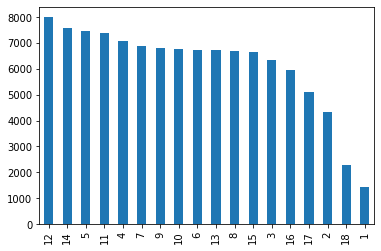

In [33]:
df.app_date.dt.isocalendar().week.value_counts().plot.bar()

In [34]:
df['app_date_week'] = df.app_date.dt.isocalendar().week

In [35]:
df.drop('app_date', axis='columns', inplace=True)

In [36]:
num_cols.append('app_date_week')

## Работа с числовыми признаками

Рассмотрим распределения числовых признаков

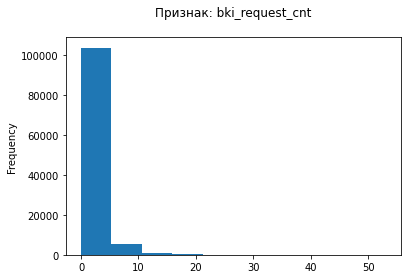

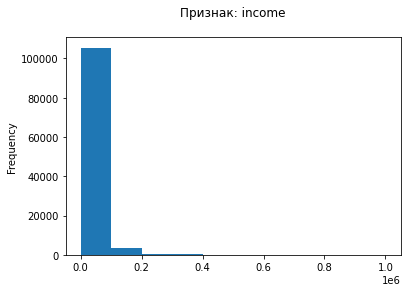

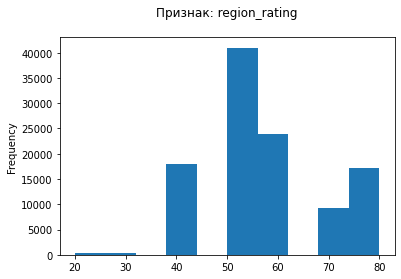

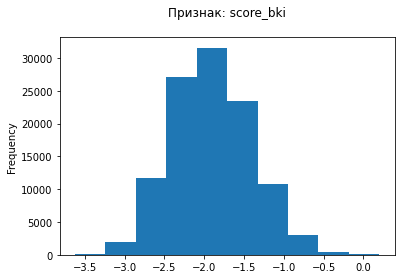

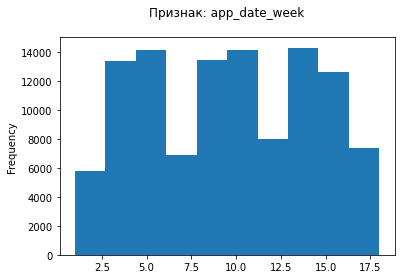

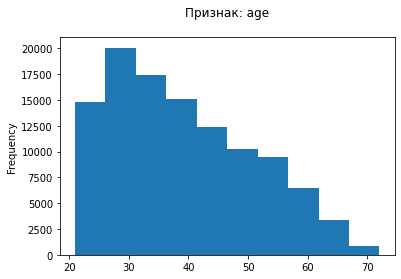

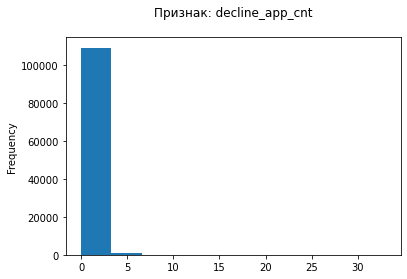

In [37]:
for cn in list(#set(df.columns) - 
               set(num_cols)):
    if (cn not in df.columns) or cn == 'app_date':
        continue
    df[cn].plot.hist()
    plt.title('Признак: {0}\n'.format(cn))
    plt.show()
    

По смещению графиков распределения от модального значения, можно выделить следующие признаки, которые стоит логарифмировать. Таким образом распределения признаков станут ближе к нормальному.

In [38]:
col_log = ['age', 'bki_request_cnt', 'decline_app_cnt', 'income']
for colname in col_log:
    df[colname] = np.log(df[colname] + 1)

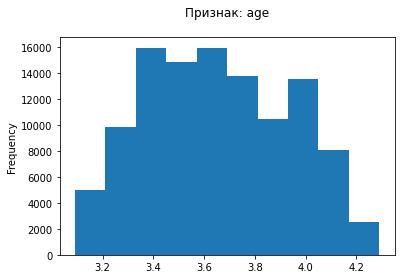

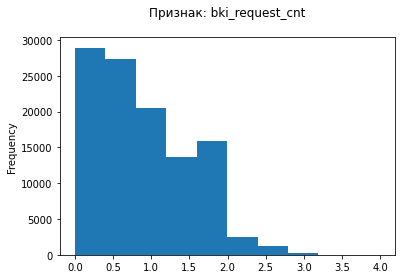

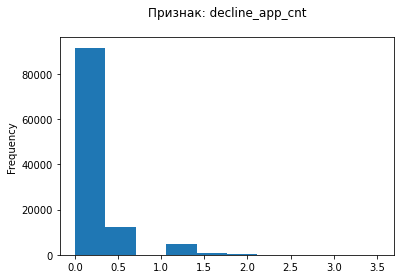

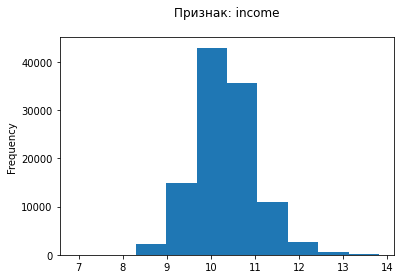

In [39]:
for cn in col_log:
    df[cn].plot.hist()
    plt.title('Признак: {0}\n'.format(cn))
    plt.show()

Также для дальнейшей работы с числовыми признаками, их следует стандартизировать - привести все, по возможности, к одинаковому диапазону принимаемых значений.

In [40]:
tmp = pd.DataFrame(StandardScaler().fit_transform(
    df[num_cols]), columns=num_cols)

In [41]:
df.drop(num_cols, axis='columns', inplace=True)
df = pd.concat([df, tmp], axis='columns')

In [42]:
df.describe()

client_id       default       is_train  education_ACD  \
count  110148.000000  73799.000000  110148.000000  110148.000000   
mean    55074.500000      0.126994       0.669999       0.002642   
std     31797.133063      0.332968       0.470215       0.051332   
min         1.000000      0.000000       0.000000       0.000000   
25%     27537.750000      0.000000       0.000000       0.000000   
50%     55074.500000      0.000000       1.000000       0.000000   
75%     82611.250000      0.000000       1.000000       0.000000   
max    110148.000000      1.000000       1.000000       1.000000   

       education_GRD  education_PGR  education_SCH  education_UGR  \
count  110148.000000  110148.000000  110148.000000  110148.000000   
mean        0.315648       0.016932       0.530886       0.133893   
std         0.464776       0.129016       0.499047       0.340538   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       1.000000       0.000000   
75%         1.000000       0.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

               sex_F          sex_M  ...   first_time=1   first_time=2  \
count  110148.000000  110148.000000  ...  110148.000000  110148.000000   
mean        0.561390       0.438610  ...       0.156580       0.422958   
std         0.496219       0.496219  ...       0.363406       0.494031   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         1.000000       0.000000  ...       0.000000       0.000000   
75%         1.000000       1.000000  ...       0.000000       1.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

        first_time=3           age  decline_app_cnt        income  \
count  110148.000000  1.101480e+05     1.101480e+05  1.101480e+05   
mean        0.254358  1.004110e-15    -3.789093e-15  7.210120e-16   
std         0.435502  1.000005e+00     1.000005e+00  1.000005e+00   
min         0.000000 -1.976836e+00    -4.188152e-01 -4.933787e+00   
25%         0.000000 -7.737452e-01    -4.188152e-01 -6.348458e-01   
50%         0.000000 -5.949589e-02    -4.188152e-01 -5.283405e-02   
75%         1.000000  8.323877e-01    -4.188152e-01  6.218273e-01   
max         1.000000  2.230861e+00     9.340604e+00  4.980702e+00   

       bki_request_cnt     score_bki  region_rating  app_date_week  
count     1.101480e+05  1.101480e+05   1.101480e+05   1.101480e+05  
mean      3.587481e-16 -4.903485e-16  -2.509444e-15   5.069311e-16  
std       1.000005e+00  1.000005e+00   1.000005e+00   1.000005e+00  
min      -1.334144e+00 -3.444269e+00  -2.812764e+00  -1.872346e+00  
25%      -1.334144e+00 -7.126592e-01  -5.167044e-01  -7.855296e-01  
50%      -2.817904e-01 -3.261521e-02  -5.167044e-01   8.392369e-02  
75%       7.705631e-01  6.741092e-01   2.486488e-01   9.533769e-01  
max       4.722032e+00  4.213712e+00   1.779355e+00   1.822830e+00  

[8 rows x 39 columns]

Посмотрим на значимость числовых признаков для нашей модели.

<AxesSubplot:>

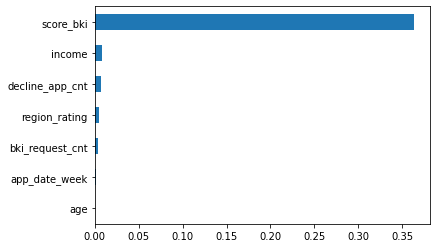

In [43]:
imp_cat = pd.Series(mutual_info_classif(df[df.is_train == 1][num_cols],
                                        df[df.is_train == 1]['default'],
                                        discrete_features=True), index=num_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самыми значимыми числовыми признаками являются:
score_bki - скоринговый балл по данным из БКИ
income - доход заемщика
Что является вполне очевидным. Возраст же влияет на предсказание дефолта заемщика меньше всего. 

Также проверим, нет ли среди числовых признаков пар сильно скоррелированных признаков.

<AxesSubplot:>

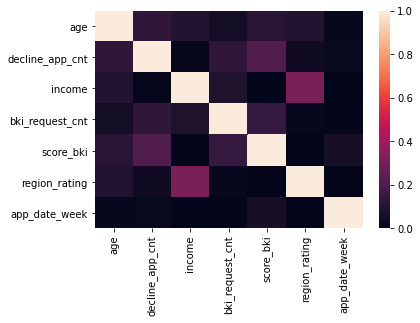

In [44]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Сильно скоррелированных пар признаков нет, никакие колонки из данных удалять не нужно

## Обучение модели

Определим функции для построения ROC-кривой и матрицы ошибок классификации модели.

In [45]:
def show_roc_curve(model, X_test, y_test):
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    plt.figure()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression Model')
    plt.legend(loc='lower right')
    plt.title('Receiver Operating Characteristic AUC = %0.10f' % roc_auc)
    plt.show()

In [46]:
def show_confusion_matrix(model, X_test, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    cf_matrix = np.array([[tp, fp], [fn, tn]])
    group_names = ['TP', 'FP', 'FN', 'TN']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure()
    sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='',  cbar=False,
                xticklabels=['Дефолт', 'Не дефолт'], yticklabels=['Дефолт', 'Не дефолт'])
    plt.title('Матрица ошибок для default')
    plt.show()

Подготовим данные для использования моделью. Разбиваем данные обратно на тренировочные и проверочные.

In [47]:
df_train = df[df['is_train'] == 1].drop(['is_train', 'client_id'], axis=1)
df_test = df[df['is_train'] == 0].drop(['default'], axis=1)
id_sub = df_test[['client_id']]

In [48]:
y = df_train['default']
X = df_train.drop(['default'], axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 36), (14760, 36), (59039,), (14760,))

### Обучим модель

#### Модель логистической регрессии.

In [50]:
model = LogisticRegression(max_iter=2000, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

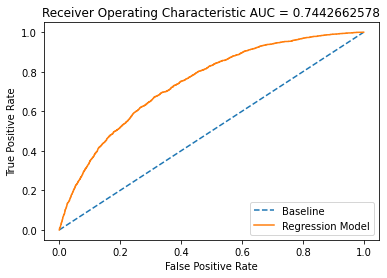

In [51]:
show_roc_curve(model, X_test, y_test)

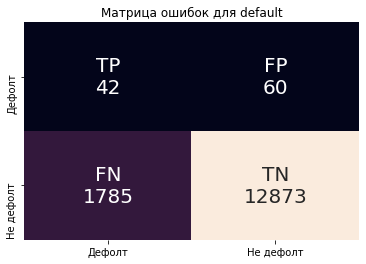

In [52]:
show_confusion_matrix(model, X_test, y_test)

#### Модель логистической регрессии с балансом признаков

Применим балансировку в модели.

In [53]:
model = LogisticRegression(class_weight='balanced',
                           max_iter=2000, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

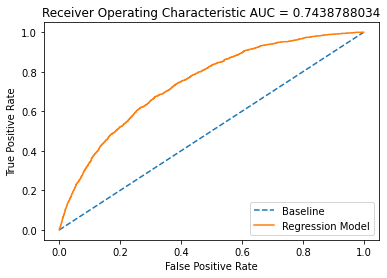

In [54]:
show_roc_curve(model, X_test, y_test)

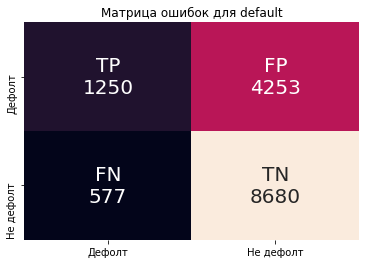

In [55]:
show_confusion_matrix(model, X_test, y_test)

Количество ложно отрицательных ошибок несколько уменьшилось, однако чрезвычайно возросоло количество ложно положительных ошибок (когда модель сочла, что клиент будет дефолтным, а на самом деле оказался не дефолтным - упущенная прибыль, если опираться на такое решение).

### Регуляризация. Гиперпараметры.

In [58]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с
# достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
# print('Accuracy: %.4f' % accuracy_score(y_test, preds))
# print('Precision: %.4f' % precision_score(y_test, preds))
# print('Recall: %.4f' % recall_score(y_test, preds))
# print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


In [59]:
model = LogisticRegression(C=1.0,
	class_weight='balanced',
	dual=False,
	fit_intercept=True,
	intercept_scaling=1,
	l1_ratio=None,
	max_iter=50,
	multi_class='auto',
	n_jobs=None,
	penalty='none',
	solver='sag',
	tol=0.001,
	verbose=0,
	warm_start=False,
                           random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=50, multi_class='auto', n_jobs=None, penalty='none',
                   random_state=42, solver='sag', tol=0.001, verbose=0,
                   warm_start=False)

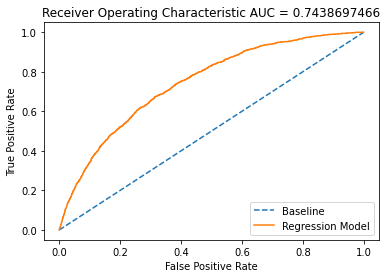

In [60]:
show_roc_curve(model, X_test, y_test)

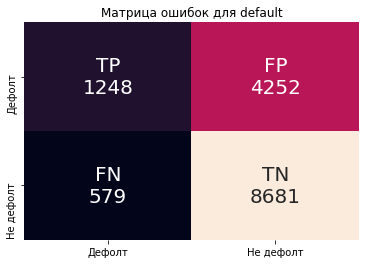

In [61]:
show_confusion_matrix(model, X_test, y_test)

Здесь, к сожалению, пока толком разобраться не удалось. Улучшения работы модели не наблюдается

## SUBMISSION

In [62]:
model_final = LogisticRegression(
    C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False
)

In [63]:
model_final.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
X_test = df_test.drop(['client_id','is_train'], axis=1)
y_pred_prob = model_final.predict_proba(X_test)[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob

In [65]:
submit.to_csv('submission.csv', index=False)